In [1]:
import time
import torch
import numpy as np
import os
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD, FastICA
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler,MaxAbsScaler
from scipy.stats import ttest_rel
import copy

import sys

sys.path.insert(0, '../')

from scripts import tabular_metrics
from scripts.differentiable_pfn_evaluation import eval_model, eval_model_range
from scripts.model_builder import (
    get_model,
    get_default_spec,
    save_model,
    load_model,
    load_model_only_inference,
)
from scripts.transformer_prediction_interface import (
    transformer_predict,
    get_params_from_config,
    TabPFNClassifier,
)

from datasets import (
    load_openml_list,
    open_cc_dids,
    open_cc_valid_dids,
    test_dids_classification,
)

base_path = '.'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the seed for the random number generator provided by PyTorch
torch.manual_seed(0)
# Set the seed for the random number generator provided by NumPy
np.random.seed(0)
# Set the seed for the random number generator provided by Python
random.seed(0)

# Load Datasets

In [2]:
def get_datasets(selector, task_type, suite='cc'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = cc_valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

In [3]:
def prepare_dataset_for_evaluation(dataset_index, test_datasets):
    dataset = test_datasets[dataset_index]
    dataset_name = dataset[0]
    dataset_size = dataset[1].shape

    print(f'Evaluation dataset name: {dataset_name} size {dataset_size} --- {dataset_index}/{len(test_datasets)}')

    xs, ys = dataset[1].clone(), dataset[2].clone()
    
    # Replace NaN values with 0
    xs[torch.isnan(xs)] = 0
    xs[torch.isinf(xs)] = 0
    
    ys[torch.isnan(ys)] = 0
    ys[torch.isinf(ys)] = 0
    
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    return train_xs, train_ys, test_xs, test_ys, dataset_name

In [4]:
max_samples = 10000
bptt = 10000

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)
cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)

# Loading longer OpenML Datasets for generalization experiments (optional)
# test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)

random.shuffle(cc_valid_datasets_multiclass)


model_string, longer, task_type = '', 1, 'multiclass'
eval_positions = [1000]
bptt = 2000
    
test_datasets, valid_datasets = get_datasets('test', task_type, suite='cc'), get_datasets('valid', task_type, suite='cc')

Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..
Number of datasets: 150
Loading breast-cancer 13 ..
Loading colic 25 ..
Loading dermatology 35 ..
Loading sonar 40 ..
Loading glass 

## Plotting Evaluations

### Plotting Utility

In [5]:
def save_dict_to_pickle_file(dictionary, filename, keys_to_exclude):
    dict_to_plot = clean_result_dictionary_for_evaluation(dictionary, keys_to_exclude) 
    with open(filename, 'wb') as file:
        pickle.dump(dict_to_plot, file)

def clean_result_dictionary_for_evaluation(dictionary, keys_to_exclude):
    def clean_result_dict(d, keys):
        new_d = {}
        for key, value in d.items():
            if key not in keys:
                if isinstance(value, dict):
                    new_d[key] = clean_result_dict(value, keys)  # Pass the 'keys' parameter instead of 'keys_to_exclude'
                else:
                    new_d[key] = copy.deepcopy(value)
        return new_d

    new_dict = clean_result_dict(dictionary, keys_to_exclude)
    return new_dict

### Plotting Functions

In [6]:

def plot_heatmap_auc_datasets_configs(ensemble_results, dataset_names, result_path):
    """
    Generate a heatmap to visualize the test data AUC scores of ensemble configurations across specified datasets.

    Parameters:
        ensemble_results (dict): A dictionary containing AUC scores for ensemble configurations and datasets.
        dataset_names (list): A list of dataset names to be included in the heatmap.
        result_path (str): The file path to save the resulting heatmap.

    Returns:
        None: The function displays the heatmap and saves it to the specified file path.
    """
    

    
    
    temp_dic_map =  {'mfeat-fourier':"fourier",
                     'mfeat-morphological':"morph",
                     'credit-approval':"credit-app",
                     'diabetes':"diabetes", 
                     'tic-tac-toe':"tic-tac-toe",
                     'vehicle':"vehicle", 
                     'analcatdata_dmft':"bankruptcy",
                     'pc4':'pc4',
                     'pc3': 'pc3',
                     "kc2":"kc2",
                     "pc1":"pc1",
                     "ilpd":"ilpd",
                     'climate-model-simulation-crashes':"climate",
                    "mfeat-karhunen": "karhunen",
                    "cmc": "cmc",
                    "credit-g":"credit-g",
                     "eucalyptus":"eucal.",
                     "mfeat-zernike":"zernike",
                     "blood-transfusion-service-center":"blood trans.",
                     "cylinder-bands":"cyl. bands",
                     "steel-plates-fault":"st. plates"}
    # Create lists to store data for the heatmap
    datasets = []
    ensemble_names = []
    auc_scores = []
    # Extract data from the ensemble_results dictionary
    for ensemble_name, ensemble_data in ensemble_results.items():
    
        for dataset_name, ensemble_dict in ensemble_data.items():
            if dataset_name in dataset_names:
                
                #dataset_name = dataset_name.replace("mfeat-", "")[:7] if dataset_name.replace("mfeat-", "")[:8][-1] == "-" else dataset_name.replace("mfeat-", "")[:8]
                
                datasets.append(temp_dic_map[dataset_name])
                
                ensemble_name = ensemble_name.replace("best_performer", "bp").replace("weighted_average", "wa")
                ensemble_names.append(ensemble_name)
                
                auc_scores.append(ensemble_dict['auc'])

    
    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'Ensemble Configuration': ensemble_names,
        'Dataset': datasets,
        'AUC Score': auc_scores
    })

    # Reshape the DataFrame to have "Dataset" as rows, "Ensemble Configuration" as columns, and "AUC Score" as values
    df_pivot = df.pivot(index='Ensemble Configuration', columns='Dataset', values='AUC Score')

    # Create the heatmap using seaborn
    plt.figure(figsize=(10, 6))
    sns_plot = sns.heatmap(df_pivot, annot=True, cmap='flare', fmt=".2f",)
    
    
    
    # plt.title("Test AUC of Ensemble Configurations Across All Datasets")
    plt.xlabel("Datasets", fontsize=18)
    plt.ylabel("Ensemble Configuration", fontsize=18)

    plt.setp(sns_plot.get_xticklabels(), rotation=30, ha='right')
    
    sns_plot.figure.set_dpi(500)
    plt.show()
    sns_plot.figure.savefig(result_path, bbox_inches='tight')
  


In [10]:
def plot_scatter_train_auc_test_auc_weighted_average_combined(dictionary, result_path):
    transformation_best_performer_aucs = {"test_auc": [],
                                          "train_auc": []}
    
    for ensemble_name, ensemble_data in dictionary.items():
        if ensemble_name == "baseline": 
            continue
            
        for dataset_name, ensemble_dict in ensemble_data.items():
            test_auc = ensemble_dict["auc"]
            
            train_auc = 0
            for model_name, model_content in ensemble_dict["model_dict"].items():
                train_auc += model_content["model_auc"] * model_content["model_weight"] 
                    
            transformation_best_performer_aucs["test_auc"].append(test_auc)
            transformation_best_performer_aucs["train_auc"].append(train_auc) 
              
    data = pd.DataFrame(transformation_best_performer_aucs)

    # Create the scatterplot with hue
    plt.figure(figsize=(8, 6))
    sns_plot = sns.scatterplot(x="train_auc", y="test_auc", data=data)

    # Fit the linear regression line
    sns_plot = sns.regplot(x="train_auc", y="test_auc", scatter=False, color="gray", data=data)

    # Set axis labels and title
    plt.xlabel("Train AUC")
    plt.ylabel("Test AUC")
    plt.title("Predicted AUC based on train data compared to test AUC on test data of weighted average transformation")

    
    # Save the plot to a file
    sns_plot.figure.savefig(result_path, bbox_inches='tight', dpi=500)
    plt.show()
    
    ## ------------------------------ C O R R E L A T I O N ------------------------------
    correlation = data['test_auc'].corr(data['train_auc'])
    print("Weighted average: Correlation between test_auc and train_auc:", correlation)

In [13]:

def plot_histogram_average_train_AUC_instance(dictionary, result_path):
    """
    Generate a bar plot to visualize the average train AUC scores across data transformations.

    Parameters:
        dictionary (dict): A dictionary containing AUC scores for different data transformations.
        result_path (str): The file path to save the resulting bar plot.

    Returns:
        None: The function displays the bar plot and saves it to the specified file path.
    """
    
    
    name_dict = {"FastICA": "ICA",
                 "FeatureAgglomeration": "Feat Aggl.",
                 "identity": "Identity",
                 "KernelPCA":"KernelPCA",
                 "PCA":"PCA",
                 "PowerTransformer":"Pow. Trans.",
                 "QuantileTransformer": "Quant. Trans.",
                 "RobustScaler": "Rob. Scaler", 
                 "TruncatedSVD":"Trunc. SVD"
    }
    # Idea: Data auc is strongly correlated with the test auc
    aucs_dict = {}
    for ensemble_name, ensemble_data in dictionary.items():
        if ensemble_name == "baseline": 
            continue
        for dataset_name, ensemble_dict in ensemble_data.items(): 
                
            for model_name_transformation, transformation_content in ensemble_dict["data_ens_dict"].items():
                transformation_name = model_name_transformation.split("-")[-1]
                transformation_name = name_dict[transformation_name]
                if transformation_name not in aucs_dict: 
                    aucs_dict[transformation_name]= []
                aucs_dict[transformation_name].append(transformation_content["data_auc"])
                

   
      
    data = pd.DataFrame(aucs_dict)
        

    # Create the histogram using Seaborn's barplot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    
    # Step 1: Melt the DataFrame to transform it into a long-form
    melted_data = data.melt()
    
    # Step 2: Calculate the mean and 95% confidence intervals for each column
    mean_data = melted_data.groupby('variable')['value'].mean().reset_index()

    
        
    ci_data = melted_data.groupby('variable')['value'].agg(lambda x: x.sem() * 1.96).reset_index()

    mean_data['ci'] = ci_data['value']
    
    mean_data = mean_data.sort_values(by="value", ascending=False).reset_index( drop=True)


    sns_plot = sns.barplot(x='variable',
                           y='value', 
                           data=mean_data, 
                           palette='flare_r',
                           color='value')

    # Step 4: Add error bars with 95% confidence intervals
    plt.errorbar(x=mean_data['variable'], 
                 y=mean_data['value'],
                 yerr=mean_data['ci'], 
                 fmt='none', 
                 color='black',
                 capsize=4)

    # Step 5: Annotate each bar with its value
    for index, row in mean_data.iterrows():
        plt.text(index, row['value'] + row['ci'], f"{row['value']:.4f}", ha='left', rotation=35, va='bottom')

    
    # Set labels and title
    plt.xlabel("", fontsize=18)
    plt.ylabel("Average Train AUC", fontsize=18)
    
    plt.ylim(0.5,1)
    #plt.title("Average AUC of Train Data Across Data Transformations", fontsize=16)

    plt.xticks(rotation=35, ha="right")  # Rotate x-axis labels for better readability

    plt.tight_layout()  # Adjust layout to prevent clipping of axis labels    
    sns_plot.figure.set_dpi(500)
    
    plt.show()
    sns_plot.figure.savefig(result_path, bbox_inches='tight')

In [14]:
def plot_histogram_times_picked_model(dictionary, result_path):
    """Plots a histogram to visualize the number of times each model is picked as the 'Best Performer'.

    The function takes a dictionary containing model ensemble data and generates a histogram plot
    to display the frequency of each model being selected as the best performer.
    
    Parameters:
        dictionary (dict): A dictionary containing the model ensemble data.
            The keys of the dictionary represent ensemble names, and the values are dictionaries
            containing data for each ensemble.
            
        result_path (str): The file path to save the resulting plot. 

    Returns:
        None: The function only displays the histogram plot and does not return any value.
    """
    models_times_dict = {}
    for ensemble_name, ensemble_data in dictionary.items():
        if "baseline" == ensemble_name or "best_performer" not in ensemble_name:
            continue
            
        for dataset_name, ensemble_dict in ensemble_data.items():
            for model_name, model_content in ensemble_dict["model_dict"].items():
                # optional: replace model_ with PFN                
                model_name = model_name.replace("model_", "")
                if model_content["model_weight"] == 1: 
                    if model_name not in models_times_dict: 

                        
                        models_times_dict[model_name] = 0
                    models_times_dict[model_name] +=1
                    
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(list(models_times_dict.items()), columns=['Model', 'Value'])
 
    df = df.sort_values(by='Value', ascending=False)
    sns.set_style("whitegrid")
    # Create the seaborn histogram
    sns_plot = sns.barplot(x='Model', y='Value', data=df, palette=sns.color_palette('flare_r', n_colors=len(df)))

    plt.xlabel("PFN-Instances")
    plt.ylabel("Number of Occurrences")
    # plt.title("Frequency of Selecting the PFN-Instances as Best Performer") Best Performer Frequency - PFN Instances 
    plt.xticks(rotation=35, ha='right')  # Rotate x-axis labels for better readability
    
    
    #-------------------------------------------------------------
    # Color x-ticks containing specific substrings differently
    for tick_label in sns_plot.get_xticklabels():
        if "bag" in tick_label.get_text():
            tick_label.set_color((122/ 255, 35/ 255, 35/ 255)) 
        elif "gp_" in tick_label.get_text():
            tick_label.set_color((21/ 255, 22/ 255, 92/ 255)) 
        elif "causal_" in tick_label.get_text():
            tick_label.set_color((166/ 255, 106/ 255, 41/ 255)) 
    #-------------------------------------------------------------
    
    # Add value labels on top of each bar
    for index, value in enumerate(df['Value']):
        sns_plot.text(index, value, str(value), ha='center', va='bottom')
    
        
    plt.tight_layout()  # Adjust layout to prevent clipping of axis labels    
    sns_plot.figure.set_dpi(500)
    
    plt.show()
    sns_plot.figure.savefig(result_path, bbox_inches='tight')

In [60]:
def ttest_auc_performance_compared_to_baseline(dictionary,  alpha=0.05):
    """
    Performs paired t-test to compare AUC performances of algorithms to a baseline.

    The function takes a dictionary containing AUC (Area Under the Curve) values for different
    algorithms' performances on multiple datasets. It calculates the paired t-test for each
    algorithm's performance against the baseline's AUC values and determines if the performance
    difference is statistically significant based on the given significance level (alpha).

    Parameters:
        dictionary (dict): A dictionary containing AUC values for different algorithms on multiple datasets.
            The keys of the dictionary represent the algorithm names, and the values are nested dictionaries
            containing the AUC values for each algorithm on various datasets.
            
        alpha (float, optional): The significance level (threshold) for the t-test.
            Default is 0.05.

    Returns:
        dict: A dictionary containing the statistical significance of AUC performance
            compared to the baseline for each algorithm. The dictionary is structured as follows:
            
            {
                'algorithm_1': {'significant': is_significant_1},
                'algorithm_2': {'significant': is_significant_2},
                ...
            }
            
            where 'is_significant_i' (True/False) indicates whether the AUC performance of the 'algorithm_i'
            is significantly different from the baseline's AUC value at the given significance level.
                       
    Note:
        The function uses the paired t-test (ttest_rel) from the scipy.stats library to calculate the
        t-statistic and p-value for comparing the AUC performances. A two-tailed test is performed to
        check for differences in both directions.
    """
    
    auc_dictionary = {}
    
    for ensemble_name, ensemble_data in dictionary.items():
        if ensemble_name not in auc_dictionary: 
            auc_dictionary[ensemble_name] = []
        for dataset_name, ensemble_dict in ensemble_data.items():
            auc_dictionary[ensemble_name].append(ensemble_dict["auc"]) 

    auc_data = pd.DataFrame(auc_dictionary)
#     sig_columns = []
    
    for ensemble_name, ensemble_auc in auc_dictionary.items():
        if "baseline" == ensemble_name:
            continue
        
        
        baseline_auc_values = np.array(auc_dictionary["baseline"])
        algorithm_auc_values = np.array(auc_dictionary[ensemble_name])

        if len(baseline_auc_values) != len(algorithm_auc_values):
            raise ValueError("Number of AUC values for the baseline and algorithm must be the same.")

        # Compute the differences between the two sets of AUC values
        differences = algorithm_auc_values - baseline_auc_values

        # Perform paired t-test
        t_statistic, p_value = ttest_rel(algorithm_auc_values, baseline_auc_values)

        # Check if the p-value is less than the significance level
        is_significant = p_value < alpha
#         if is_significant:
#             sig_columns.append(ensemble_name)
        auc_dictionary[ensemble_name]= {"significant": is_significant}
        
    auc_dictionary.pop("baseline")
    # Create a DataFrame from the dictionary
    
#     auc_data = auc_data[['baseline'] + sig_columns]
    
    return auc_dictionary, auc_data

# PFN Ensemble Class : Ensemble over TabPFNs with Different Data Transformations
"""" we introduce the PFNENsemble technique....

The `PFNEnsemble` class is designed to perform ensembling over TabPFNs and/or different data transformations. The main process path involves a two-step procedure: first, fitting the PFNs to the training data, and second, using the trained PFN instances with the respective data transformation to predict probabilities on the test data.

### Initialization
- `model_storage_folders`: A list of folders containing the pre-trained TabPFN instances.
- `device`: The device on which the PFN instances are loaded and trained (e.g., "cpu" or "gpu").
- `N_ensemble_configurations`: The number of ensemble configurations to use during training.
- `verbose`: A flag indicating whether to display verbose output during the ensemble process.

### Methods

1. `fit(train_xs, train_ys)`: Fits the PFN instances to the training data. As the TabPFN gets inputs, as well as labels of the training data we can estimate the performance of the test data based on the train data. 
   - `train_xs`: The input features of the training data.
   - `train_ys`: The target labels of the training data.

2. `predict_proba(test_xs, data_ensemble_config=None, model_ensemble_config=None, data_preprocess_config=None, multiple_models=False, pre_processing=False)`: Predicts probabilities on the test data using the ensembled PFN instances.
   - `test_xs`: The input features of the test data.
   - `data_ensemble_config`: A dictionary specifying the data-level ensembling configuration.
   - `model_ensemble_config`: A dictionary specifying the PFN instance-level ensembling configuration.
   - `data_preprocess_config`: A dictionary specifying the data preprocessing configuration.
   - `multiple_models`: A flag indicating whether to use multiple PFN instances for ensembling.
   - `pre_processing`: A flag indicating whether to perform data preprocessing before ensembling.

### Data Ensembling and PFN Ensembling
The class supports the following ensembling configurations:

- **Data Ensembling**: Data Ensembling uses data transformations, which can be applied to the data and after the forward pass aggregated with different methods. The available preprocessing methods are specified in the `data_preprocess_config` dictionary. 

- **PFN Ensembling**: PFN ensembling can be performed using PFN instances, whereby their individual results can be aggregated using different techniques.

Data ensembling can be combined with PFN ensembling for a more comprehensive approach.

### Weight Computation
As PFNs have the advantage to have access to the training inputs and labels we can leverage that to compute a metric which gives us a prediction of how well a PFN-Instance / data transformation will perform on the test data. We therefore compute weights based on the expected prediction performance for each used PFN / transformation.
The two weight types are supported: "weighted_average" and "best_performer".


In [17]:
class PFNEnsemble:
    def __init__(self, 
                 model_storage_folders=["models_gp"],
                 device="cpu",
                 N_ensemble_configurations=5,
                 verbose=False):
        # Maps model_index to loaded model
        self.model_dict = {}
        self.data_ens_dict = {}
        
        for model_storage_folder in model_storage_folders:
            # Iterate over all files in the model_path directory
            for model_index, model_string in enumerate(os.listdir(model_storage_folder)):
                if model_string.endswith('.cpkt'):  # Assuming the models have a .cpkt extension
                    loaded_model = TabPFNClassifier(base_path=model_storage_folder,
                                                    model_string=model_string[:-5],
                                                    N_ensemble_configurations=N_ensemble_configurations,
                                                    batch_size_inference=1, 
                                                    no_preprocess_mode=True)
                    
        
                    self.model_dict[model_string.split('.')[0]] = {"model": loaded_model}

    def fit(self, train_xs, train_ys):
        for model_name, model_content in self.model_dict.items():
            model = model_content["model"]
            model.fit(train_xs, train_ys)
            
    def get_split_of_train_data_simple(self, train_x, train_y, split_share):
        temp_split_pos = int(train_x.shape[0] * split_share)
        
        temp_split_train_x = train_x[:temp_split_pos]
        temp_split_test_x = train_x[temp_split_pos:]
        
        temp_split_train_y = train_y[:temp_split_pos]
        temp_split_test_y = train_y[temp_split_pos:]
        return [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
    
                
    def get_split_of_train_data_bagging(self, train_x, train_y, split_share, number_splits):
        splits = [] # each entry has format: [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
        # todo repeat the following number_splits times and add each time to splits
        for i in range(number_splits):
            temp_split_indices = random.sample(range(len(train_x)), int(split_share * len(train_x)))
            temp_split_train_x = [train_x[i] for i in temp_split_indices]
            temp_split_test_x = [train_x[i] for i in range(len(train_x)) if i not in temp_split_indices]

            temp_split_train_y = [train_y[i] for i in temp_split_indices]
            temp_split_test_y = [train_y[i] for i in range(len(train_y)) if i not in temp_split_indices]
            splits.append((temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y))
        return splits
    
    
    def get_split_of_train_data_pasting(self, train_x, train_y, split_share):
        splits = [] # each entry has format: [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
        # todo repeat the following number_splits times and add each time to splits
        list_of_indices_to_sample = list(range(len(train_x)))
        while len(list_of_indices_to_sample) > 1: # need at least two 
            len_list_to_sample = len(list_of_indices_to_sample)
            if len_list_to_sample <= int(split_share * len(train_x)) * 2:
                temp_split_train_indices = list_of_indices_to_sample[:len_list_to_sample//2]
                temp_split_test_indices = list_of_indices_to_sample[len_list_to_sample//2:]
            else:    
                temp_split_train_indices = random.sample(list_of_indices_to_sample, int(split_share * len(train_x)))
                remaining_list_indices = [x for x in list_of_indices_to_sample if x not in temp_split_train_indices]
                temp_split_test_indices = random.sample(remaining_list_indices,int(split_share * len(train_x)))
                
            # remove indices which has been sampled in temp_split_indices from list_of_indices_to_sample
            list_of_indices_to_sample  = [x for x in list_of_indices_to_sample if x not in temp_split_train_indices + temp_split_test_indices]

            temp_split_train_x = [train_x[i] for i in temp_split_train_indices]
            temp_split_test_x = [train_x[i] for i in temp_split_test_indices]

            temp_split_train_y = [train_y[i] for i in temp_split_train_indices]
            temp_split_test_y = [train_y[i] for i in temp_split_test_indices]

            splits.append((temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y))
        return splits
            
        
    def get_train_auc_of_model(self,model,splits): 
        total_auc = 0
        for temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y in splits:
            model.fit(temp_split_train_x, temp_split_train_y)
            prediction_ = model.predict_proba(temp_split_test_x)
            auc = tabular_metrics.auc_metric(temp_split_test_y, prediction_)
            total_auc += auc
        total_auc /= len(splits)
        return total_auc
        
    def compute_weights(self, level, weight_type):
        
        if weight_type == f"weighted_average":
            if level == 'data':
                sum_of_auc = {}
                for key in self.data_ens_dict.keys():
                    model_name = key.split('-')[0]
                    if model_name not in sum_of_auc.keys():
                        sum_of_auc[model_name] = 0
                    sum_of_auc[model_name] += self.data_ens_dict[key][f'{level}_auc']
                    
                for data_ens_key, data_ens_content in self.data_ens_dict.items():
                    self.data_ens_dict[data_ens_key][f"{level}_weight"] = data_ens_content[f"{level}_auc"] / sum_of_auc[data_ens_key.split('-')[0]]
                
            else: # model here


                #sum_of_auc = sum([i[f'{level}_auc']  for i in self.model_dict.values()])
                
                self.model_dict = dict(sorted(self.model_dict.items(), key=lambda item: item[1][f'{level}_auc'], reverse=True))
                
                sum_of_weights = 0
                for ensemble_index, model_dict_key in enumerate(self.model_dict):
                    if ensemble_index != len(self.model_dict) - 1:
                        self.model_dict[model_dict_key][f"{level}_weight"] = (1/2)**(ensemble_index+1)
                        sum_of_weights += self.model_dict[model_dict_key][f"{level}_weight"]
                    else: 
                        self.model_dict[model_dict_key][f"{level}_weight"] = 1 - sum_of_weights
                    
                    


                #for ensemble_index, model_name in self.model_dict.items():
                #    self.model_dict[ensemble_index][f"{level}_weight"] = self.model_dict[ensemble_index][f"{level}_auc"] / sum_of_auc
                
          
        elif weight_type == f"best_performer":
            
            if level == 'data':
                max_aucs = {}
                for key in self.data_ens_dict.keys():
                    model_name = key.split('-')[0]
                    if model_name not in max_aucs.keys():
                        max_aucs[model_name] = self.data_ens_dict[key][f'{level}_auc']
                    max_aucs[model_name] = max(max_aucs[model_name], self.data_ens_dict[key][f'{level}_auc'])
                
                max_auc_keys = {}
                for data_ens_key, data_ens_content in self.data_ens_dict.items():
                    if data_ens_content[f'{level}_auc'] == max_aucs[data_ens_key.split('-')[0]]:
                        max_auc_keys[data_ens_key.split('-')[0]] = data_ens_key
                
                for data_ens_key in self.data_ens_dict.keys():
                    if data_ens_key in max_auc_keys.values():
                        self.data_ens_dict[data_ens_key][f'{level}_weight'] = 1
                    else:
                        self.data_ens_dict[data_ens_key][f'{level}_weight'] = 0
                
            else:
                max_model_auc = max([i[f'{level}_auc'] for i in self.model_dict.values()])
                
                max_auc_key = None
                for model_key, model_content in self.model_dict.items():
                    if model_content[f'{level}_auc'] == max_model_auc:
                        max_auc_key = model_key
                        break
                
                for model_key in self.model_dict.keys():
                    if model_key == max_auc_key:
                        self.model_dict[model_key][f'{level}_weight'] = 1
                    else:
                        self.model_dict[model_key][f'{level}_weight'] = 0

        
    def get_splits_of_train_data(self, full_train_x, full_train_y, split_type, split_share, number_splits):
        # compute the train data splits for later AUC computation
        if split_type == "simple":
            return self.get_split_of_train_data_simple(train_x=full_train_x, train_y=full_train_y, split_share=split_share)
        elif split_type == "bagging":
            return self.get_split_of_train_data_bagging(train_x=full_train_x, train_y=full_train_y, split_share=split_share,number_splits=number_splits)
        elif split_type == "pasting": 
            return self.get_split_of_train_data_pasting(train_x=full_train_x, train_y=full_train_y, split_share=split_share)
        else:
            print("todo raise error")
        
        
    def predict_proba(self, 
                      test_xs, 
                      data_ensemble_config = None,
                      model_ensemble_config = None,
                      data_preprocess_config = None, 
                      multiple_models=False,
                      pre_processing=False ):
        
         # ------------------- only preprocessing with one model --------------------------
        if multiple_models is False and pre_processing is True:
            print("predict_proba use only the baseline model and data-ensembling as no moe config is given! ")
            
            baseline_model, baseline_name = None, None
            
            for model_name, model_content in self.model_dict.items():
                if "baseline" in model_name:
                    baseline_model = model_content["model"]
                    baseline_name = model_name
                    break
    
            if baseline_model is None:  
                raise NotImplementedError(f'The baseline_model could not be found for predict proba.')

            train_xs, train_ys = baseline_model.X_, baseline_model.y_
            
            # add identity
            data_preprocess_config['sklearn_transformations'].append(("identity",None))
            
            # APPLY DATA PREPROCESSING / AUGMENTATION
            for transformer_name, transformer in data_preprocess_config["sklearn_transformations"]:
                transformation_key = baseline_name + '-' + transformer_name
                self.data_ens_dict[transformation_key] = {}

                if transformer_name != 'identity':
                    train_xs_t = transformer.fit_transform(train_xs)
                    
                    number_features = min(100,train_xs_t.shape[-1])
                    
                    train_xs_t = train_xs_t[:,:number_features]
                    test_xs_t = transformer.transform(test_xs)[:,:number_features]
                else:
                    number_features = min(100,train_xs.shape[-1])

                    train_xs_t = train_xs[:,:number_features]
                    test_xs_t = test_xs[:,:number_features]
                
                self.data_ens_dict[transformation_key]['train_data'] = (train_xs_t, train_ys)
                self.data_ens_dict[transformation_key]['test_data'] = test_xs_t
                
                splits = self.get_splits_of_train_data(full_train_x=train_xs_t,
                                                       full_train_y=train_ys,
                                                       split_type=data_ensemble_config["data_split_type"], 
                                                       split_share=data_ensemble_config["data_split_share"],
                                                       number_splits=data_ensemble_config["data_number_splits"])

                # Compute AUC performance of train data
                self.data_ens_dict[transformation_key]['data_auc'] = float(self.get_train_auc_of_model(model=baseline_model,
                                                                                               splits=splits))
                baseline_model.fit(train_xs_t, train_ys)
                self.data_ens_dict[transformation_key]['test_preds'] = baseline_model.predict_proba(self.data_ens_dict[transformation_key]['test_data'])
                
            baseline_model.fit(train_xs, train_ys)
            # after having collected the auc / ce /... scores of the models of the train set, we want to 
            # compute the weights for the final forward pass
            self.compute_weights(level="data",
                                 weight_type=data_ensemble_config["data_weight_type"])
            
            prediction_weighted = 0
            for data_ens_key, data_ens_content in self.data_ens_dict.items():
                prediction_weighted += data_ens_content['test_preds'].copy() * data_ens_content['data_weight']
                
            # Storing the weighted predictions as predictions of the model as well
            self.model_dict[baseline_name]['test_preds'] = prediction_weighted
            
            return prediction_weighted

            
        # ------------------------- only model ensembling ----------------------------------------
        elif multiple_models is True and pre_processing is False:
            print("predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given")
            
            for model_name, model_content in self.model_dict.items():
                
                train_xs, train_ys = model_content['model'].X_, model_content['model'].y_
                
                # compute the train data splits for later AUC computation
                splits = self.get_splits_of_train_data(full_train_x=train_xs,
                                                       full_train_y=train_ys,
                                                       split_type=model_ensemble_config["model_split_type"], 
                                                       split_share=model_ensemble_config["model_split_share"],
                                                       number_splits=model_ensemble_config["model_number_splits"])

                
                # Compute AUC performance of train data 
                self.model_dict[model_name]['model_auc'] = float(self.get_train_auc_of_model(model=model_content['model'],
                                                                                                splits=splits))

                self.model_dict[model_name]['model'].fit(train_xs, train_ys) # overwrite the training data in the model again!
                model_content['test_preds'] = model_content['model'].predict_proba(test_xs)
            
            # after having collected the auc scores of the models of the train set, we want to compute the weights for the final forward pass
            self.compute_weights(level="model",
                                 weight_type=model_ensemble_config["model_weight_type"])
           
            prediction_weighted = 0
            for model_name, model_content in self.model_dict.items():
                prediction_weighted += model_content['test_preds'].copy() * model_content['model_weight']
                          
            return prediction_weighted
        
        
        # ---------------------- both datapreprocessing for each in moe ensembling ------------------------------    
        else: 
            print("data preprocessing and moe both used!" )
            
            for model_name, model_content in self.model_dict.items():
                    
                train_xs, train_ys = model_content['model'].X_, model_content['model'].y_

                # add identity
                data_preprocess_config['sklearn_transformations'].append(("identity",None))

                # APPLY DATA PREPROCESSING / AUGMENTATION
                for transformer_name, transformer in data_preprocess_config["sklearn_transformations"]:
                    transformation_key = model_name + '-' + transformer_name
                    self.data_ens_dict[transformation_key] = {}

                    if transformer_name != 'identity':
                        train_xs_t = transformer.fit_transform(train_xs)

                        number_features = min(100,train_xs_t.shape[-1])

                        train_xs_t = train_xs_t[:,:number_features]
                        test_xs_t = transformer.transform(test_xs)[:,:number_features]
                    else:
                        number_features = min(100,train_xs.shape[-1])

                        train_xs_t = train_xs[:,:number_features]
                        test_xs_t = test_xs[:,:number_features]


                    self.data_ens_dict[transformation_key]['train_data'] = (train_xs_t, train_ys)
                    self.data_ens_dict[transformation_key]['test_data'] = test_xs_t

                    splits = self.get_splits_of_train_data(full_train_x=train_xs_t,
                                                           full_train_y=train_ys,
                                                           split_type=data_ensemble_config["data_split_type"], 
                                                           split_share=data_ensemble_config["data_split_share"],
                                                           number_splits=data_ensemble_config["data_number_splits"])


                    # Compute AUC performance of train data
                    self.data_ens_dict[transformation_key]['data_auc'] = float(self.get_train_auc_of_model(model=model_content['model'],
                                                                                                           splits=splits))
                    model_content['model'].fit(train_xs_t, train_ys)
                    
                    self.data_ens_dict[transformation_key]['test_preds'] = model_content['model'].predict_proba(self.data_ens_dict[transformation_key]['test_data'])
               
                    
                    

                model_content['model'].fit(train_xs, train_ys)
                # after having collected the auc scores of the models of the train set, we want to 
            
            # compute the weights for the data ensembles
            self.compute_weights(level="data", weight_type=data_ensemble_config["data_weight_type"])
            
            
            for model_name in self.model_dict.keys():
                model_prediction_weighted = 0
                model_auc_weighted = 0
                for data_ens_name, data_ens_content in self.data_ens_dict.items():
                    if data_ens_name.split('-')[0] == model_name:
                        #print(data_ens_content)
                        model_prediction_weighted += data_ens_content['test_preds'].copy() * \
                                                                                    data_ens_content['data_weight']
                        model_auc_weighted += data_ens_content['data_auc'] * \
                                                                                    data_ens_content['data_weight']
                self.model_dict[model_name]['test_preds'] = model_prediction_weighted
                self.model_dict[model_name]['model_auc'] = model_auc_weighted
            
            # compute the weights for the final model ensemble
            self.compute_weights(level="model",
                                 weight_type=model_ensemble_config["model_weight_type"])
            
            prediction_weighted = 0
            for model_name, model_content in self.model_dict.items():
                prediction_weighted += model_content['test_preds'] * model_content['model_weight']

            return prediction_weighted

# Computation of ensembling with a diverse set of trained TabPFNs specialized for different priors
## Function Description

In the following cell, we conduct an evaluation of ensembling using a multitude of differently trained TabPFNs, each acting as an "expert" specialized for a specific prior distribution. The primary goal is to explore the effectiveness of ensembling these experts on test data, leveraging their expertise in handling distinct underlying structures.

### Weighting Metric:
For this evaluation, we employ the "model_auc" as the weighting metric. This metric allows us to assess the performance of the ensembled models against the baseline tabpfn predictions, where the input data and corresponding labels are known during the training phase.

### Weight Types and Split Types:
To evaluate the ensembling, we utilize different weight types and split types in combination with the weighting metric. These configurations help predict the performance of the tabpfn when combined with a specific strategy to weigh the various tabpfn instances to improve the performance of the test data, based on the performance on the training data.

### Specialized Prior Distributions:
The evaluated TabPFNs have been trained using three distinct types of prior distributions:
1. **Gaussian Process Priors (GPs):** Some experts have been trained exclusively on Gaussian process priors, making them proficient in handling datasets governed by such distributions.
2. **Structural Causal Models (SCMs):** Other experts have been trained solely on structural causal models, allowing them to excel in datasets governed by these specific structures.
3. **Mixture of GPs and SCMs:** Several experts have been trained on a combination of Gaussian process priors and structural causal models, enabling them to handle datasets exhibiting mixed underlying structures.

### Aggregation and Weighting Strategies:
Following the forward pass with the loaded data, we adopt diverse strategies to aggregate and weight the results of the TabPFNs based on their performance on the training data's AUC. These strategies aim to leverage the strengths of each expert, resulting in a combined model that performs better in their respective "expertise" fields.

### Main Idea:
The main idea behind this evaluation is to assemble a diverse set of experts with specialized knowledge in handling different types of underlying structures. By ensembling these experts, we seek to improve the overall performance of the combined model compared to the baseline tabpfn. The evaluation proceeds through multiple steps, each comprising a unique configuration of weighting metric, weight types, and split types in conjunction with various tabpfn instances.

The computed results for each configuration are stored in the "ensemble_results" dictionary, enabling us to analyze the impact of each ensemble approach on the model's performance. This evaluation plays a crucial role in understanding how ensembling can harness the expertise of diverse specialists to achieve enhanced performance across a wide range of datasets. As a result, it provides valuable insights into leveraging specialized knowledge to tackle complex real-world problems effectively.

The evaluation cell first checks for previously computed results and loads them from the file if available. If not, it performs the evaluation for each dataset within the specified range of "number_iterations." For each dataset, we compare the performance of the tabpfn model with the baseline model and compute their respective AUC metrics. We then proceed to perform ensembling for various configurations, calculating the AUC metrics for each ensemble and storing the results.

Finally, the evaluation results are saved to a pickle file for future reference and further analysis.


In [ ]:
evaluations_folder = "./evaluations/experts/"
file_name = f"{evaluations_folder}only_experts_ensemble_results.pickle"


model_paths = ["./models_gp","./models_causal", "./models_bag"]#,"./baseline"]    
    
baseline_classifier = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="model_bag_baseline",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1, 
                                     no_preprocess_mode=True)

# Ensemble configuration 

model_weighting_metrics = ["model_auc"]
model_weight_types = ["best_performer","weighted_average"] 
model_split_types =["simple", "bagging", "pasting"]


# Configure run 
ensemble_results = {}

# Indices of the datasets to predict
start = 0
end =  2
number_iterations = range(max(start, 0),min(end,len(test_datasets)))

if os.path.exists(file_name):
    with open(file_name, 'rb') as file:
        ensemble_results = pickle.load(file)
else:
    for dataset_index in number_iterations:

        train_xs, train_ys, test_xs, test_ys, dataset_name = prepare_dataset_for_evaluation(dataset_index=dataset_index, test_datasets=test_datasets)

        # compare to normal tabpfn
        baseline_classifier.fit(train_xs, train_ys)
        prediction_tabpfn = baseline_classifier.predict_proba(test_xs)
        auc_baseline = tabular_metrics.auc_metric(test_ys, prediction_tabpfn)

        # add computed results to ensemble_results
        if "baseline" not in ensemble_results:
            ensemble_results["baseline"] = {}

        if dataset_name not in ensemble_results["baseline"]:
            ensemble_results["baseline"][dataset_name] = {}


        baseline_dict = {"auc":auc_baseline.item()}
        ensemble_results["baseline"][dataset_name]= baseline_dict


        for weighting_metric in model_weighting_metrics: 
            for weight_type in model_weight_types: 
                for split_type in model_split_types:
                    print(f"Current configuration: weighting_metric {weighting_metric}, weight_type {weight_type}, split_type {split_type}")


                    model_ensemble_config = {"model_weighting_metric":weighting_metric,
                                             "model_weight_type":weight_type,
                                             "model_split_type":split_type,
                                             "model_split_share":0.5, 
                                             "model_number_splits": 5}

                    data_preprocess_config = None
                    data_ensemble_config = None

                    # create classifier with configuration 
                    classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths, N_ensemble_configurations=1, device=device)

                    classifier_ensemble.fit(train_xs, train_ys)
                    prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                    data_ensemble_config=data_ensemble_config,
                                                                    model_ensemble_config=model_ensemble_config,
                                                                    data_preprocess_config=data_preprocess_config, 
                                                                    multiple_models=True,
                                                                    pre_processing=False)

                    auc_ensemble = tabular_metrics.auc_metric(test_ys, prediction_)
                    
                    # add computed results to results dict
                    ensemble_name = f"{weight_type}-{split_type}"

                    if ensemble_name not in ensemble_results:
                        ensemble_results[ensemble_name] = {}

                    if dataset_name not in ensemble_results[ensemble_name]:
                        ensemble_results[ensemble_name][dataset_name] = {}
                        
                    ensemble_dict = {"auc":auc_ensemble.item(),
                                    "model_dict":classifier_ensemble.model_dict,
                                    "data_ens_dict":classifier_ensemble.data_ens_dict}

                    ensemble_results[ensemble_name][dataset_name]= ensemble_dict
                    
    save_dict_to_pickle_file(ensemble_results, file_name, keys_to_exclude= ["model", "train_data", "test_data", "test_preds"])


## ONLY EXPERT EVALUATION

In [ ]:

##---------------------------- S T A R T - E V A L U A T I O N - P L O T S ----------------------------
ensemble_results = clean_result_dictionary_for_evaluation(ensemble_results, keys_to_exclude= ["model", "train_data", "test_data", "test_preds"])

##---------------------------- H E A T M A P S ----------------------------
start, stop = 0, 15

dataset_names = [dataset[0] for dataset_index,dataset in enumerate(test_datasets) if start <= dataset_index <= stop]

dataset_names= ["analcatdata_dmft","cmc", "credit-approval", "credit-g", "diabetes", "eucalyptus",
                "mfeat-fourier", "mfeat-karhunen", "mfeat-morphological", "mfeat-zernike", "tic-tac-toe", 
                "blood-transfusion-service-center", "climate-model-simulation-crashes", "cylinder-bands", 
                "steel-plates-fault" ]

plot_heatmap_auc_datasets_configs(ensemble_results, dataset_names, f"{evaluations_folder}dataset[selection]-plot_heatmap_auc_datasets_configs.png" )





##------------------------------------------------------------------------------------------------------------
##---------------------------- T I M E S - M O D E L - H I S T O G R A M  ------------------------------------

plot_histogram_times_picked_model(ensemble_results, f"{evaluations_folder}plot_histogram_times_picked_model.png" )

##---------------------------- S T A T I S T I C A L - T E S T S -------------------------
ttest_auc_performance_compared_to_baseline(dictionary=ensemble_results, alpha=0.05)

# Computation of all ensemble configurations with only data-ensembling
## Function Description

In the following cell, we perform an evaluation of ensembling using various data transformations in combination with the baseline tabpfn instance. The purpose of this evaluation is to investigate how different preprocessing techniques impact the performance of the tabpfn model combined with different techniques on ensembling on test data compared to the original baseline results.

### Weighting Metric:
The evaluation uses "data_auc" as the weighting metric. This metric is employed to assess the performance of the ensembled models against the baseline tabpfn predictions based on the auc of the training data where the input as well as the labels are known to the model.

### Weight Types and Split Types:
To evaluate the ensembling, different weight types and split types are utilized in combination with the weighting metric. These configurations are used to predict the performance of the tabpfn when combined with a specific data transformation of the test data based on the train data.

### Data Preprocessing Functionalities:
The data preprocessing functionalities involve two main steps:
1. **Bagging with Different Feature Permutations:** This process entails applying bagging with various feature permutations to the data. Bagging is a technique that involves training multiple instances of the same model with different subsets of the training data and then combining their predictions. In this case, feature permutations refer to rearranging the order of features to create different subsets for training as the tabpfn transformer is not invariant to the feature order.

2. **Different Data Transformations from sklearn Library:** Several data transformations from the sklearn library are utilized for preprocessing. These transformations include:
   - PCA (Principal Component Analysis)
   - KernelPCA (Kernel Principal Component Analysis)
   - TruncatedSVD (Truncated Singular Value Decomposition)
   - FastICA (Fast Independent Component Analysis)
   - FeatureAgglomeration (Feature Agglomeration)
   - RobustScaler (Robust Scaler)
   - PowerTransformer (Power Transformer)
   - QuantileTransformer (Quantile Transformer)

### Main Idea:
The main idea behind this evaluation is to determine whether a specific data preprocessing technique allows the tabpfn model to extract the underlying distribution's structure more effectively. By comparing the ensembled model's performance with different preprocessing configurations to the baseline tabpfn model, it becomes possible to identify which data transformation improves the tabpfn's performance.

The evaluation proceeds in multiple steps, with each step comprising a distinct configuration of weighting metric, weight types, and split types in conjunction with different data transformations. The computed results for each configuration are stored in the "ensemble_results" dictionary.

The evaluation cell begins by loading previously computed results from the file if available. Otherwise, it performs the evaluation for each dataset within the specified range of "number_iterations." For each dataset, the tabpfn is compared to the baseline model, and their respective AUC (Area Under the Curve) metrics are computed. Then, the ensembling is performed for various configurations, and the AUC metrics for each ensemble are computed and stored.

Finally, the results are saved to a pickle file for future use.


In [ ]:
# C O N F I G U R A T I O N 
model_paths = ["./baseline"]

evaluations_folder = "./evaluations/data/"

file_name = f"{evaluations_folder}only_data_ensemble_results.pickle"

baseline_classifier = TabPFNClassifier(device=device, base_path="./baseline", model_string="model_bag_baseline",
                                     N_ensemble_configurations=1, batch_size_inference=1, no_preprocess_mode=True,
                                     multiclass_decoder='permutation', feature_shift_decoder=False)

# Ensemble configuration 
weighting_metrics = ["data_auc"]
weight_types = ["best_performer","weighted_average"]
split_types =["simple", "bagging", "pasting"]

# Data preprocessing configuration
data_preprocess_config = {"N_ensemble_configurations": 1,
                          "sklearn_transformations": [
                              ("RobustScaler_no_unit_variance",RobustScaler(unit_variance=False)),
                              ("RobustScaler_no_unit_variance",RobustScaler(unit_variance=True)),
                              ("PowerTransformer",PowerTransformer()),
                              ("PowerTransformer",PowerTransformer(standardize=False)),
                              ("MaxAbsScaler",MaxAbsScaler()),
                              ("QuantileTransformer_100",QuantileTransformer(n_quantiles=100)),
                              ("QuantileTransformer_250",QuantileTransformer(n_quantiles=250)),
                              ("QuantileTransformer_50",QuantileTransformer(n_quantiles=50))
                                                  ]
                         }

# Configure run 
ensemble_results = {}

# Indices of the datasets to predict
start = 0
end =  30
number_iterations = range(max(start, 0),min(end,len(test_datasets)))

    
#---------------------------- S T A R T - E V A L U A T I O N - R U N ----------------------------

if os.path.exists(file_name):
    with open(file_name, 'rb') as file:
        ensemble_results = pickle.load(file)
else:
    for dataset_index in number_iterations:
        train_xs, train_ys, test_xs, test_ys, dataset_name = prepare_dataset_for_evaluation(dataset_index=dataset_index, test_datasets=test_datasets)
        
        
        # compare to baseline tabpfn
        baseline_classifier.fit(train_xs, train_ys)
        prediction_tabpfn = baseline_classifier.predict_proba(test_xs)
        auc_baseline = tabular_metrics.auc_metric(test_ys, prediction_tabpfn)

        # add computed results to ensemble_results
        if "baseline" not in ensemble_results:
            ensemble_results["baseline"] = {}

        if dataset_name not in ensemble_results["baseline"]:
            ensemble_results["baseline"][dataset_name] = {}


        baseline_dict = {"auc":auc_baseline.item()}
        ensemble_results["baseline"][dataset_name]= baseline_dict

        # Ensemble Configurations 
        for weighting_metric in weighting_metrics: 
            for weight_type in weight_types: 
                for split_type in split_types:
                    print(f"Current configuration: weighting_metric {weighting_metric}, weight_type {weight_type}, split_type {split_type}")

                    data_ensemble_config = {"data_weighting_metric":weighting_metric,
                                            "data_weight_type":weight_type,
                                            "data_split_type":split_type,
                                            "data_split_share":0.5, 
                                            "data_number_splits": 3}

                    
                    # create classifier with configuration 
                    classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths,
                                                      N_ensemble_configurations=data_preprocess_config["N_ensemble_configurations"],
                                                      device=device)

                    classifier_ensemble.fit(train_xs, train_ys)
                    prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                    model_ensemble_config= None,
                                                                    data_ensemble_config=data_ensemble_config,
                                                                    data_preprocess_config=data_preprocess_config,
                                                                    multiple_models=False,
                                                                    pre_processing=True )

                    auc_ensemble  = tabular_metrics.auc_metric(test_ys, prediction_)

                    # add computed results to results dict
                    ensemble_name = f"{weight_type}-{split_type}"

                    if ensemble_name not in ensemble_results:
                        ensemble_results[ensemble_name] = {}

                    if dataset_name not in ensemble_results[ensemble_name]:
                        ensemble_results[ensemble_name][dataset_name] = {}
                        
                    ensemble_dict = {"auc":auc_ensemble.item(),
                                    "model_dict":classifier_ensemble.model_dict,
                                    "data_ens_dict":classifier_ensemble.data_ens_dict}

                    ensemble_results[ensemble_name][dataset_name]= ensemble_dict
                    
    save_dict_to_pickle_file(ensemble_results, file_name, keys_to_exclude= ["model", "train_data", "test_data", "test_preds"])



In [ ]:
#
##---------------------------- S T A R T - E V A L U A T I O N - P L O T S ----------------------------
#
ensemble_results = clean_result_dictionary_for_evaluation(ensemble_results, keys_to_exclude=["model", "train_data", "test_data", "test_preds"])

##---------------------------- H E A T M A P S ----------------------------
# FOR THE FINAL EVALUATION

dataset_names = [ 'mfeat-fourier',
 'mfeat-morphological',
 'credit-approval',
 'diabetes', 
 'tic-tac-toe',
 'vehicle', 
 'analcatdata_dmft',
 'pc4','pc4', 'pc3',
 'kc2', 'pc1', 'ilpd', 'climate-model-simulation-crashes']
plot_heatmap_auc_datasets_configs(ensemble_results, dataset_names, f"{evaluations_folder}data_dataset[selection]-plot_heatmap_auc_datasets_configs.png" )

#
##------------------------------------------------------------------------------------------------------------
##---------------------------- I N S T A N C E S - A U C - H I S T O G R A M  --------------------------------

# FOR THE FINAL EVALUATION
plot_histogram_average_train_AUC_instance(ensemble_results, f"{evaluations_folder}plot_histogram_average_test_AUC_instance.png")

##---------------------------- S T A T I S T I C A L - T E S T S -------------------------
ttest_auc_performance_compared_to_baseline(dictionary=ensemble_results,alpha=0.05)
#

# Combined Data and Expert Ensembling

## Introduction
In this experiment, we assess the performance of a combined approach of data and expert-level ensembling. The objective is to leverage both data-driven and expert-driven methodologies to create a robust ensemble model. This markdown document outlines the steps involved in the evaluation process.

## Data Transformations
Before proceeding with the ensembling, a variety of datatransformations are applied to the input data. These transformations prepare the data for subsequent processing and enhance the performance of the ensemble model.

## PFNs Application
The transformed data tensors are passed through a set of PFNs. These PFNs represent the experts in the ensemble and capture their unique insights into the data.

## Aggregation and Splitting Techniques
Similar to the data-only ensembling and expert-only ensembling, different aggregation and splitting techniques are employed for both levels of ensembling. These techniques are crucial for capturing diverse perspectives from the data and experts, respectively.

## AUC Score Computation
To evaluate the performance of the ensemble, the Area Under the Curve (AUC) scores are calculated using the train data. These scores serve as a basis for weighing the elements of the ensemble, optimizing it for improved performance on the training data.

## Weighed Ensemble
Using the computed AUC scores, all elements of the ensemble are weighed appropriately. This step ensures that the ensemble is optimized to achieve the highest possible AUC on the training data, leading to enhanced generalization capabilities.

## Prediction Computation
With the elements now properly weighed, the final predictions are computed. The combination of data and expert-level ensembling allows us to capitalize on the strengths of both approaches, resulting in more accurate predictions.

## Results Storage
All the computed results, including AUC scores, ensemble weights, and final predictions, are stored in a dictionary. This organized data structure enables easy access and analysis of the ensemble's performance and the impact of different techniques used.

## Conclusion
The combined approach of data and expert-level ensembling shows great promise in enhancing predictive accuracy and robustness. By incorporating diverse data perspectives and expert knowledge, the ensemble outperforms individual models and delivers more accurate predictions. The stored results in the dictionary facilitate further analysis and comparison of different ensembling strategies, guiding future model development and refinement.

In [19]:
evaluations_folder = "./evaluations/combined/"
file_name = f"{evaluations_folder}combined_data_and_experts_ensemble_results.pickle"


model_paths = ["./models_gp","./models_causal","./models_bag"]    

baseline_classifier = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="model_bag_baseline",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1, 
                                     no_preprocess_mode=True,
                                     multiclass_decoder='permutation',
                                     feature_shift_decoder=False)#??? 

data_weighting_metrics = ["data_auc"]  
data_weight_types = ["best_performer"]#,"weighted_average"] 
data_split_types =["simple"]#, "bagging", "pasting"] 

model_weighting_metrics = ["model_auc"]  
model_weight_types = ["best_performer"]#,"weighted_average"] 
model_split_types =["simple"]#, "bagging", "pasting"] 

data_preprocess_config = {"N_ensemble_configurations": 1,
                          "sklearn_transformations": [("PCA",PCA()),
                                                      ("KernelPCA",KernelPCA()),
                                                      ("TruncatedSVD",TruncatedSVD()),
                                                      ("FastICA",FastICA()),
                                                      ("FeatureAgglomeration",FeatureAgglomeration()),
                                                      ("RobustScaler",RobustScaler()),
                                                      ("PowerTransformer",PowerTransformer()),
                                                      ("QuantileTransformer",QuantileTransformer(n_quantiles=100))
                                                     ]
                         }

# Configure run 
ensemble_results = {}

start = 0
end = 5
number_iterations = range(max(start, 0),min(end,len(test_datasets)))# Index of the dataset to predict

if os.path.exists(file_name):
    with open(file_name, 'rb') as file:
        ensemble_results = pickle.load(file)
else:
    for evaluation_dataset_index in number_iterations:
        train_xs, train_ys, test_xs, test_ys, dataset_name = prepare_dataset_for_evaluation(dataset_index=evaluation_dataset_index, test_datasets=test_datasets)
        
        # compare to baseline tabpfn
        baseline_classifier.fit(train_xs, train_ys)
        prediction_tabpfn = baseline_classifier.predict_proba(test_xs)
        auc_baseline = tabular_metrics.auc_metric(test_ys, prediction_tabpfn)

        # add computed results to ensemble_results
        if "baseline" not in ensemble_results:
            ensemble_results["baseline"] = {}

        if dataset_name not in ensemble_results["baseline"]:
            ensemble_results["baseline"][dataset_name] = {}


        baseline_dict = {"auc":auc_baseline.item()}
        ensemble_results["baseline"][dataset_name]= baseline_dict
        
        
        # MoE Configurations ---------------------
        for model_weighting_metric in model_weighting_metrics: 
            for model_weight_type in model_weight_types: 
                for model_split_type in model_split_types:
                    print(f"Current model_configuration: model_weighting_metric {model_weighting_metric}, model_weight_type {model_weight_type}, model_split_type {model_split_type}")
                    # --------------------------------
                    model_ensemble_config = {"model_weighting_metric":model_weighting_metric,
                                             "model_weight_type":model_weight_type,
                                             "model_split_type":model_split_type,
                                             "model_split_share":0.5, 
                                             "model_number_splits": 5}

             
                    # create classifier with configuration 
                    classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths,
                                               N_ensemble_configurations=data_preprocess_config["N_ensemble_configurations"],
                                               device=device)

                    classifier_ensemble.fit(train_xs, train_ys)
                    
                    for data_weighting_metric in data_weighting_metrics: 
                            for data_weight_type in data_weight_types: 
                                for data_split_type in data_split_types:

                                    data_ensemble_config = {"data_weighting_metric":data_weighting_metric,
                                                            "data_weight_type":data_weight_type,
                                                            "data_split_type":data_split_type,
                                                            "data_split_share":0.5, 
                                                            "data_number_splits": 5}

                                    start_time = time.time()

                                    prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                                    model_ensemble_config=model_ensemble_config,
                                                                                    data_ensemble_config=data_ensemble_config,
                                                                                    data_preprocess_config=data_preprocess_config,
                                                                                    multiple_models=True,
                                                                                    pre_processing=True)


                                    # Print the evaluation time
                                    print(f"Evaluation predict proba time: { time.time() - start_time:.4f} seconds")



                                    auc_ensemble = tabular_metrics.auc_metric(test_ys, prediction_)
                                    
                                    # add computed results to results dict
                                    ensemble_name = f"m_{model_weight_type}-m_{model_split_type}-d_{data_weight_type}-d_{data_split_type}"

                                    if ensemble_name not in ensemble_results:
                                        ensemble_results[ensemble_name] = {}

                                    if dataset_name not in ensemble_results[ensemble_name]:
                                        ensemble_results[ensemble_name][dataset_name] = {}

                                    ensemble_dict = {"auc":auc_ensemble.item(),
                                                    "model_dict":classifier_ensemble.model_dict,
                                                    "data_ens_dict":classifier_ensemble.data_ens_dict}

                                    ensemble_results[ensemble_name][dataset_name]= ensemble_dict

    save_dict_to_pickle_file(ensemble_results, file_name, keys_to_exclude= ["model", "train_data", "test_data", "test_preds"])

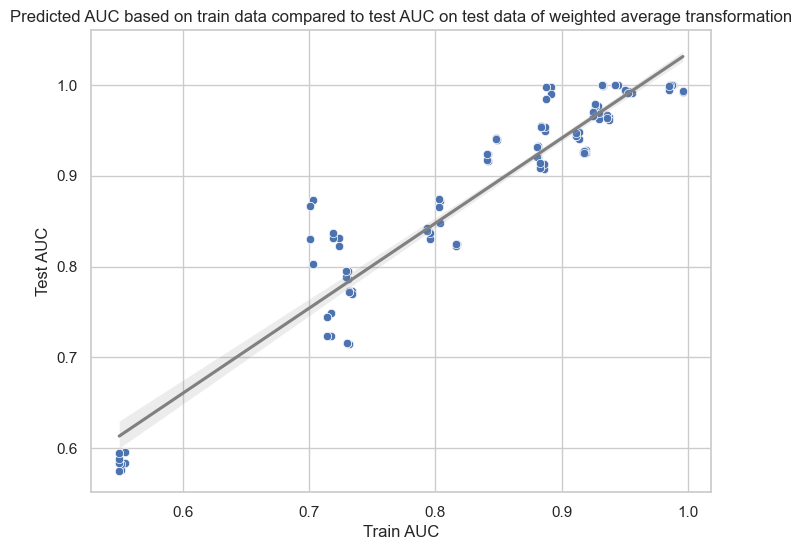

Weighted average: Correlation between test_auc and train_auc: 0.9561176383524309


In [162]:
plot_scatter_train_auc_test_auc_weighted_average_combined(ensemble_results, f"{evaluations_folder}plot_scatter_train_auc_test_auc_weighted_average_combined.png")


## KDE Plot for Test AUC

In [138]:
sig_dict, auc_data = ttest_auc_performance_compared_to_baseline(dictionary=ensemble_results,alpha=0.1)

In [139]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [140]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

In [141]:
rename_dict = {'baseline':'baseline', 
 'm_best_performer-m_simple-d_best_performer-d_simple': 'm_best-m_simp-d_best',
    'm_best_performer-m_simple-d_weighted_average-d_simple': 'm_best-m_simp-d_weighted',
    'm_best_performer-m_bagging-d_best_performer-d_simple': 'm_best-m_bag-d_best',
    'm_best_performer-m_bagging-d_weighted_average-d_simple': 'm_best-m_bag-d_weighted',
    'm_weighted_average-m_simple-d_best_performer-d_simple': 'm_weighted-m_simp-d_best',
    'm_weighted_average-m_simple-d_weighted_average-d_simple': 'm_weighted-m_simp-d_weighted',
    'm_weighted_average-m_bagging-d_best_performer-d_simple': 'm_weighted-m_bag-d_best',
    'm_weighted_average-m_bagging-d_weighted_average-d_simple': 'm_weighted-m_bag-d_weighted'
}

auc_data.rename(columns=rename_dict,inplace=True)

In [142]:
column_list = []
for i in auc_data.columns:
    column_list += [i]*30

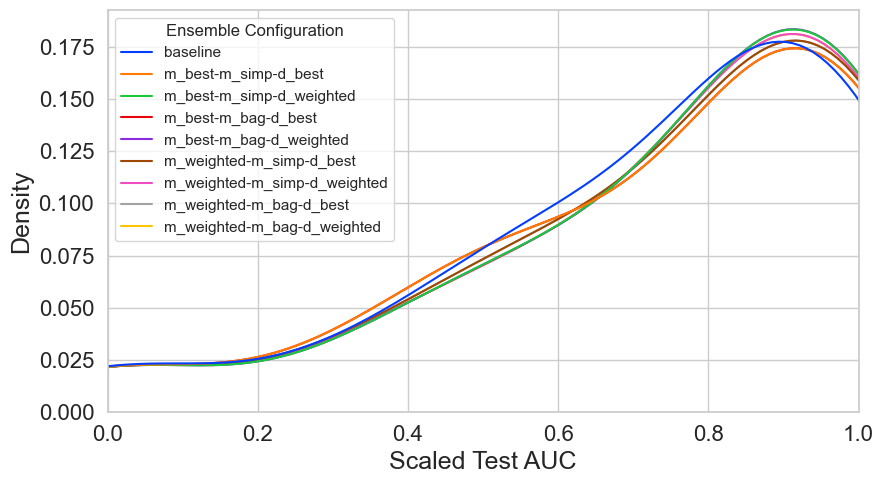

In [161]:
plt.figure(figsize=(9,5))
sns.set_style('whitegrid')

scaler=scalers[1]
data = scaler.fit_transform(auc_data.values).reshape(-1, order='F')

auc_melt = pd.DataFrame()
auc_melt['aucs'] = data
auc_melt['ensemble'] = column_list

sns.kdeplot(data=auc_melt,x='aucs', hue='ensemble', palette='bright')
plt.xlim(0,1)
plt.xlabel("Scaled Test AUC", fontsize=18)
plt.ylabel("Density", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend = plt.gca().get_legend()
legend.set_title("Ensemble Configuration")
plt.tight_layout()
plt.savefig('./evaluations/combined/kde_plot_auc.png', bbox_inches='tight')